In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    syllable_aliases,
    clean_ticks,
    format_pval,
    savefig
)
from rl_analysis.util import whiten
from rl_analysis.photometry.encoding_average.util import run_inference_and_ppc
from joblib import Parallel, delayed
from scipy.stats import pearsonr
from sklearn import linear_model, model_selection

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import multiprocessing as mp
import warnings

In [3]:
from sklearn import preprocessing, pipeline

In [4]:
from rl_analysis.io.df import (
    dlight_exclude_toml,
)

# Handy functions

In [5]:
def ncount_transitions(seq, K=100):
    trans = np.zeros((K, K), dtype="int64")
    flat_coords = np.ravel_multi_index((seq[:-1], seq[1:]), trans.shape)
    trans.flat = np.bincount(flat_coords, minlength=trans.size)
    return trans

In [6]:
def split_array(x, mapping=None, index_name="syllable"):
    index = pd.Series(np.arange(len(x)))
    rows = pd.Series(data=x.tolist(), index=index.map(mapping))
    rows.index.name = index_name
    return rows

# Data loading

In [7]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [8]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
dlight_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [9]:
use_dct = dlight_exclude_toml(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.toml"),
    **analysis_config["dlight_common"]
)

In [10]:
df_filtered = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("uuid", "in", list(use_dct.keys()))],
)

snr_persession = df_filtered.drop_duplicates("uuid").groupby("mouse_id")["snr"].mean()

In [11]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [12]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"
if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")

dirname, filename = os.path.split(features_save_file)
file, ext = os.path.splitext(filename)
file = os.path.join(proc_dirs["dlight"], file)

if lagged_cfg["estimate_within_bin"]:
    file = f"{file}_withinbin"

In [13]:
use_features = []
for _use_win in lagged_cfg["use_windows"]:
    use_features += [f"{_}_{_use_win}" for _ in lagged_cfg["use_neural_features"]]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

In [14]:
dlight_and_scalar_df = pd.read_parquet(features_save_file)
dlight_and_scalar_df = dlight_and_scalar_df.loc[
    dlight_and_scalar_df["uuid"].isin(df_filtered["uuid"].unique())
].copy()

In [15]:
dlight_and_scalar_df = dlight_and_scalar_df.loc[
    dlight_and_scalar_df["window_tup"].isin(lagged_cfg["use_windows"])
].copy()

In [16]:
try:
    dlight_and_scalar_df = dlight_and_scalar_df.set_index("window_tup", append=True)
except KeyError:
    pass

In [17]:
wins = dlight_and_scalar_df.index.get_level_values(-1).unique()

In [18]:
idx = pd.IndexSlice

In [19]:
dfs = []
for _idx in tqdm(wins):
    use_vals = dlight_and_scalar_df.loc[idx[:, _idx], lagged_cfg["use_neural_features"]]
    use_vals.columns = [f"{_}_{_idx}" for _ in use_vals.columns]
    use_vals.index = use_vals.index.droplevel(-1)
    dfs.append(use_vals)

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
meta_cols = dlight_and_scalar_df.columns.difference(
    dlight_and_scalar_df.filter(regex="dff").columns
)
meta_df = dlight_and_scalar_df[meta_cols].loc[idx[:, _idx], :]
meta_df.index = meta_df.index.droplevel(-1)
dlight_and_scalar_df = pd.concat(dfs, axis=1).join(meta_df)

In [21]:
target_syllables = list(syllable_aliases.keys())
group_keys = ["mouse_id"]

In [22]:
sns.set_style("white")
sns.set_context("notebook")

In [23]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], "syllable_stats_photometry_offline.toml")
)
# syllable_stats = toml.load(os.path.join(proc_dirs["dlight"],"syllable_stats_online.toml"))
mapping = {int(k): int(v) for k, v in syllable_stats["syllable_to_sorted_idx"].items()}
reverse_mapping = {
    int(k): int(v) for k, v in syllable_stats["sorted_idx_to_syllable"].items()
}
sorted_syllables = np.array(
    list(syllable_stats["syllable_to_sorted_idx"].keys())
).astype("int")

In [24]:
da_stats_df = pd.read_parquet(
    os.path.join(proc_dirs["closed_loop_behavior"], "da-vs-learning-per-syllable.parquet")
)
norm_df = pd.read_parquet(
    os.path.join(
        raw_dirs["closed_loop_behavior"], "learning_aggregate.parquet"
    )
)

# Model functions

In [25]:
import numpyro
from numpyro.infer import MCMC, NUTS
from jax import random

In [26]:
# COMMENT OUT IF USING A GPU
numpyro.set_host_device_count(mp.cpu_count())
numpyro.set_platform("cpu")

In [27]:
from scipy.stats import zscore

In [28]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

## Normalization of learning data

In [29]:
targets = syllable_aliases.keys()

In [30]:
learning_per_syllable = (
    norm_df.loc[
        (norm_df["syllable"] == norm_df["target_syllable"])
        & (norm_df["session_number"].isin([1, 2]))
        & (norm_df["stim_duration"] == 0.25)
        & (norm_df["area"] == "snc (axon)")
    ]
    .groupby(
        ["mouse_id", "area", "opsin", "syllable", "session_number", "target_syllable"]
    )
    .mean()
)

/tmp/ipykernel_1389598/59940035.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [31]:
learning_range = norm_df.loc[
    (norm_df["stim_duration"] == 0.25) & (norm_df["area"] == "snc (axon)")
].copy()
learning_range = learning_range.loc[
    (
        (learning_range["session_number"] <= 0)
        & (learning_range["date"].dt.dayofweek == 0)
    )
].copy()
learning_range["date (rounded)"] = learning_range["date"].dt.floor("d")

In [32]:
from collections import defaultdict

In [33]:
# either average sessions or do all to all
diff_dist = defaultdict(list)
fold_dist = defaultdict(list)
count_dist = defaultdict(list)
key = "count"
for _target in tqdm(targets):
    for _mouse, mouse_df in learning_range.groupby("mouse_id"):
        mouse_df = mouse_df[mouse_df["syllable"] == _target].sort_values(
            by="date (rounded)"
        )
        mouse_df_ref = mouse_df.copy()

        if len(mouse_df) == 0:
            continue

        # for each mouse, target, session should only be 1 possible baseline
        for _idx, row in mouse_df.iterrows():
            dts = row["date (rounded)"] - mouse_df_ref["date (rounded)"]
            dts = dts.apply(lambda x: x.days)
            # print(dts)
            # this is where we choose which day diff to use as a baseline
            base_rows = mouse_df_ref.loc[(dts >= 1) & (dts < np.inf)]
            for _, base_row in base_rows.iterrows():
                diff_dist[(_mouse, _target)].append(row[key] - base_row[key])
                try:
                    fold_change = np.log2(row[key] / base_row[key])
                except:
                    fold_change = np.nan
                fold_dist[(_mouse, _target)].append(fold_change)
                count_dist[(_mouse, _target)].append(row[key])

  0%|          | 0/6 [00:00<?, ?it/s]

In [34]:
count_mu = learning_range.groupby(["mouse_id", "syllable"], observed=True)[
    "count"
].mean()
count_sig = learning_range.groupby(["mouse_id", "syllable"], observed=True)[
    "count"
].std()

In [35]:
learning_per_syllable["change_count_z"] = learning_per_syllable.groupby(
    ["mouse_id", "syllable"]
)["change_count"].transform(lambda x: (x) / np.nanstd(diff_dist[x.name]))
learning_per_syllable["log2_fold_change_count_z"] = learning_per_syllable.groupby(
    ["mouse_id", "syllable"]
)["log2_fold_change_count"].transform(
    lambda x: (x - np.nanmean(fold_dist[x.name])) / np.nanstd(fold_dist[x.name])
)
learning_per_syllable["count_z"] = learning_per_syllable.groupby(
    ["mouse_id", "syllable"]
)["count"].transform(lambda x: (x - count_mu[x.name]) / count_sig[x.name])

In [36]:
syllable_classes = toml.load(os.path.join(proc_dirs["closed_loop_behavior"], "behavior_classes.toml"))
syllable_map = {}

for k, v in syllable_classes.items():
    for _syllable in v:
        syllable_map[_syllable] = k

# Per syllable and mouse usage

In [37]:
rle_df = pd.read_parquet(rle_save_file)

In [38]:
corr_file = f"{file}_lag_usage_and_scalars_correlations_dls.parquet"
shuffle_file = f"{file}_lag_usage_and_scalars_shuffle_for_index.parquet"

In [39]:
obs_corrs = pd.read_parquet(corr_file)

In [40]:
shuffle_df = pd.read_parquet(shuffle_file)

In [41]:
use_feature = "signal_reref_dff_z_max_(0.0, 0.3)"
mouse_list = list(obs_corrs.index.get_level_values("mouse_id").unique())
mouse_list = [_ for _ in mouse_list if "dlight-chrimson" in _]

In [42]:
agg_keys = ["bin", "time_bin", "mouse_id", "syllable"]
shuffle_agg_keys = ["bin", "time_bin", "syllable", "idx"]
final_agg_keys = ["syllable", "mouse_id", "bin"]
group_keys = ["syllable", "mouse_id"]

In [43]:
use_obs_corrs = obs_corrs.xs(use_feature, level="feature")

In [44]:
use_obs_corrs = use_obs_corrs.loc[
    (use_obs_corrs.index.get_level_values("syllable").isin(sorted_syllables[:]))
]

In [45]:
shuffle_agg = (
    shuffle_df.xs(use_feature, level="feature").groupby(shuffle_agg_keys).mean()
)

In [46]:
use_obs_corrs = use_obs_corrs.groupby(
    agg_keys
).mean()  

shuffle_mus = shuffle_agg.groupby(shuffle_agg_keys[:-1]).mean()
shuffle_sigs = shuffle_agg.groupby(shuffle_agg_keys[:-1]).std()

z_obs_mu = ((use_obs_corrs - shuffle_mus) / shuffle_sigs).groupby(final_agg_keys).mean()
obs_mu = use_obs_corrs

In [47]:
raw_syllable_corrs = obs_mu.groupby(final_agg_keys)["count"].mean()
z_syllable_corrs = z_obs_mu.groupby(final_agg_keys)["count"].mean()

In [48]:
z_syllable_corrs = (
    (
        z_syllable_corrs.groupby(final_agg_keys[:-1])
        .transform(lambda x: x.rolling(3, 1, True).mean())
    )
    .groupby(group_keys + ["bin"])
    .mean()
)

In [49]:
pal_len = z_syllable_corrs.index.get_level_values("syllable").nunique()

In [50]:
from rl_analysis.info.util import dm_entropy

In [51]:
uuid_list = list(df_filtered["uuid"].unique())

In [52]:
use_rle_df = rle_df.loc[
    (rle_df["syllable"] >= 0)
    & (rle_df["session_number"] <= 0)
    & (rle_df["uuid"].isin(uuid_list))
    & (rle_df["date"].dt.dayofweek == 0)
].copy()
use_rle_df["syllable_sorted"] = use_rle_df["syllable"].map(mapping)
tm_df = (
    use_rle_df.groupby(["mouse_id", "session_number", "uuid"])["syllable_sorted"]
    .apply(lambda x: ncount_transitions(x, K=len(mapping)))
    .dropna()
)

/tmp/ipykernel_1389598/2110564721.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  flat_coords = np.ravel_multi_index((seq[:-1], seq[1:]), trans.shape)


In [53]:
tm_df_rows = tm_df.apply(lambda x: split_array(x, mapping=reverse_mapping)).stack()
tm_df_rows = tm_df_rows.apply(lambda x: np.array(x))
tm_df_rows = tm_df_rows.rename("tm_row")

In [54]:
totals = tm_df_rows.groupby(group_keys).sum()

In [55]:
tqdm.pandas()

In [56]:
totals_sz = totals.apply(lambda x: x.sum())

In [57]:
ents = totals.progress_apply(
    lambda x: dm_entropy(
        x[: syllable_stats["truncate"]],
        alpha=1.0 / syllable_stats["truncate"],
        marginalize=False,
        axis=None,
    )
).rename("entropy_out_syllable")

  0%|          | 0/1102 [00:00<?, ?it/s]

In [58]:
ri_ci = 0.9
top = 1 - ((1 - ri_ci) / 2)
bottom = (1 - ri_ci) / 2

In [59]:
reinforcement_index_per_syllable_z = (
    z_syllable_corrs.groupby(group_keys)
    .std()
    .rename("reinforcement_index_per_syllable_z")
)

In [60]:
reinforcement_index_per_syllable_z = reinforcement_index_per_syllable_z.loc[
    reinforcement_index_per_syllable_z.index.get_level_values("mouse_id").isin(
        mouse_list
    )
]

In [61]:
learning_ave = learning_per_syllable.groupby(["mouse_id", "syllable"]).mean()
learning_ave = learning_ave.loc[
    learning_ave.index.get_level_values("mouse_id").isin(mouse_list)
]

In [62]:
pd.concat(
    [
        reinforcement_index_per_syllable_z.loc[
            sorted_syllables[: syllable_stats["truncate"]]
        ]
        .groupby("mouse_id").median(),
        learning_ave.groupby("syllable")
        .rank()
        .groupby("mouse_id")
        .median()["log2_fold_change_count_z"],
    ],
    axis=1,
).corr()

,reinforcement_index_per_syllable_z,log2_fold_change_count_z
reinforcement_index_per_syllable_z,1.00000,0.65984
log2_fold_change_count_z,0.65984,1.00000


# Per mouse entropy...

In [63]:
corr_file = f"{file}_lag_global_entropy_correlations_for_index_per_mouse.parquet"
shuffle_file = f"{file}_lag_global_entropy_shuffle_for_index_per_mouse.parquet"

In [64]:
obs_corrs = pd.read_parquet(corr_file)
shuffle_df = pd.read_parquet(shuffle_file)

In [65]:
agg_keys = ["bin", "time_bin", "mouse_id", "syllable"]
shuffle_agg_keys = ["bin", "time_bin", "mouse_id", "idx"]
final_agg_keys = ["mouse_id", "syllable", "bin"]
group_keys = ["syllable", "mouse_id"]

In [66]:
use_obs_corrs = obs_corrs.xs(
    (use_feature, "dlight_bin"), level=("dlight_bin_feature", "feature")
)["entropy"]

In [67]:
shuffle_agg = (
    shuffle_df.xs((use_feature, "dlight_bin"), level=("dlight_bin_feature", "feature"))
    .groupby(shuffle_agg_keys)["entropy"]
    .mean()
)

In [68]:
use_obs_corrs = use_obs_corrs.groupby(
    agg_keys
).mean()  

shuffle_mus = shuffle_agg.groupby(shuffle_agg_keys[:-1]).mean()
shuffle_sigs = shuffle_agg.groupby(shuffle_agg_keys[:-1]).std()

z_obs_mu = ((use_obs_corrs - shuffle_mus) / shuffle_sigs).groupby(final_agg_keys).mean()
obs_mu = use_obs_corrs

In [69]:
raw_entropy_corrs = obs_mu.groupby(final_agg_keys).mean().dropna()
z_entropy_corrs = z_obs_mu.groupby(final_agg_keys).mean().dropna()
z_entropy_corrs = z_entropy_corrs.loc[np.isfinite(z_entropy_corrs)]

In [70]:
z_entropy_corrs = (
    (
        z_entropy_corrs.groupby(final_agg_keys[:-1])
        .transform(lambda x: x.rolling(3, 1, True).mean())
    )
    .groupby(group_keys + ["bin"])
    .mean()
)

In [71]:
ri_ci = 0.9
top = 1 - ((1 - ri_ci) / 2)
bottom = (1 - ri_ci) / 2

In [72]:
entropy_index_per_syllable_z = (
    z_entropy_corrs.groupby(group_keys).std().rename("entropy_index_per_syllable_z")
)

In [73]:
learning_ave = learning_per_syllable.groupby(["syllable", "mouse_id"]).mean()
learning_ave = learning_ave.loc[
    learning_ave.index.get_level_values("mouse_id").isin(mouse_list)
]

In [74]:
entropy_index_per_syllable_z = entropy_index_per_syllable_z.loc[
    entropy_index_per_syllable_z.index.get_level_values("mouse_id").isin(mouse_list)
]

In [75]:
entropy_index_per_syllable_z = entropy_index_per_syllable_z.reset_index()
entropy_index_per_syllable_z["syllable"] = entropy_index_per_syllable_z["syllable"].map(
    reverse_mapping
)

In [76]:
entropy_index_per_syllable_z = (
    entropy_index_per_syllable_z.set_index(group_keys).sort_index().iloc[:, 0]
)

In [77]:
r_df = pd.concat(
    [
        reinforcement_index_per_syllable_z.loc[
            sorted_syllables[: syllable_stats["truncate"]]
        ]
        .groupby("mouse_id").median(),
        learning_ave.groupby("syllable")
        .rank()
        .groupby("mouse_id")
        .median()["log2_fold_change_count_z"],
        entropy_index_per_syllable_z.loc[sorted_syllables[: syllable_stats["truncate"]]]
        .groupby("mouse_id").median(),
    ],
    axis=1,
)

In [79]:
splits = model_selection.LeavePOut(p=2)

In [80]:
import rl_analysis.photometry.encoding_average.models as np_models

In [81]:
feature_combinations = {
    "entropy_learning": {
        "x": ["entropy_index_per_syllable_z"],
        "y": "log2_fold_change_count_z",
    },
    "reinforcement_learning": {
        "x": ["reinforcement_index_per_syllable_z"],
        "y": "log2_fold_change_count_z",
    },
    "reinforcement_entropy": {
        "x": ["reinforcement_index_per_syllable_z"],
        "y": "entropy_index_per_syllable_z",
    },
}

xvals = np.linspace(-2, 2, 100).reshape(-1, 1)
from numpyro.infer import Predictive

nshuffles = 1000

use_model = np_models.simple_regression

In [82]:
kernel = NUTS(use_model)
mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=20,
    chain_method="parallel",
    progress_bar=False,
)

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [83]:
ppc = {}
correlation = {}
shuffle_correlation = {}
preprocs = {}

for (name, dct) in tqdm(feature_combinations.items()):

    x_preproc = preprocessing.StandardScaler()
    y_preproc = preprocessing.StandardScaler()

    preprocs[name] = {}
    preprocs[name]["x"] = x_preproc
    preprocs[name]["y"] = y_preproc

    feature_df = r_df.copy()

    x_cols = dct["x"]
    y_col = dct["y"]

    feature_df[x_cols] = x_preproc.fit_transform(feature_df[x_cols])
    feature_df[y_col] = y_preproc.fit_transform(feature_df[[y_col]])

    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=FutureWarning)
        mcmc.run(
            rng_key_,
            feature_df[x_cols].values,
            feature_df[y_col].values.ravel(),
        )

    full_samples = mcmc.get_samples()
    predictive = Predictive(use_model, full_samples)
    ppc[name] = predictive(rng_key_, xvals, None)

    obs_observed = []
    delays = []
    for train_idx, test_idx in splits.split(feature_df):
        train_x, train_y = (
            feature_df.iloc[train_idx][x_cols],
            feature_df.iloc[train_idx][y_col],
        )
        test_x, test_y = (
            feature_df.iloc[test_idx][x_cols],
            feature_df.iloc[test_idx][y_col],
        )

        delays.append(
            delayed(run_inference_and_ppc)(
                train_x.values,
                train_y.values,
                test_x.values,
                None,
                None,
                use_model,
                rng_key=rng_key_,
                ncpus=1,
                standardize=False,
                mcmc_kwargs={"num_warmup": 1000, "num_samples": 2000},
            )
        )
        obs_observed.append(test_y.values)

    obs_observed = np.concatenate(obs_observed)
    results = Parallel(verbose=10, n_jobs=-1)(delays)

    # get predictions--average MCMC samples
    all_y = [(_[1]["y"]).mean(axis=0) for _ in results]
    all_y = np.concatenate(all_y)
    correlation[name] = pearsonr(all_y, obs_observed)[0]
    shuffle_correlation[name] = [
        pearsonr(all_y, obs_observed[np.random.permutation(len(obs_observed))])[0]
        for _ in range(nshuffles)
    ]

  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more

In [84]:
setup_plotting_env()

In [85]:
aliases = {
    "reinforcement_index_per_syllable_z": "DA-usage",
    "entropy_index_per_syllable_z": "DA-entropy",
    "learning_z": "Opto-DA learning (z)",
    "log2_fold_change_count_z": "Opto-DA learning\n(ave. rank)",
}

In [86]:
alpha = 0.68
hi_cutoff = 1 - (1 - alpha) / 2
lo_cutoff = (1 - alpha) / 2

In [87]:
color = sns.color_palette()[0]

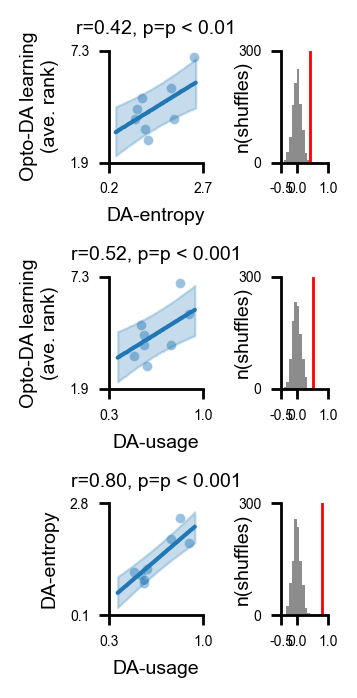

In [88]:
fig, ax = plt.subplots(
    len(ppc.keys()),
    2,
    figsize=(1.8, 3.5),
    gridspec_kw={"width_ratios": [2] * len(x_cols) + [1]},
    sharex=False,
    sharey=False,
)

for rax, (combo_name, _ppc) in zip(ax, ppc.items()):

    feature_df = r_df.copy()
    _invert_y = preprocs[combo_name]["y"].inverse_transform
    _invert_x = preprocs[combo_name]["x"].inverse_transform

    lo_ci = np.quantile(ppc[combo_name]["y"], lo_cutoff, axis=0)
    hi_ci = np.quantile(ppc[combo_name]["y"], hi_cutoff, axis=0)
    mu = np.quantile(ppc[combo_name]["y"], 0.5, axis=0)

    lo_ci = _invert_y(lo_ci[:, None]).ravel()
    hi_ci = _invert_y(hi_ci[:, None]).ravel()
    mu = _invert_y(mu[:, None]).ravel()

    shuffle_bins = np.linspace(-1, 1, 25)
    pval = (correlation[combo_name] < shuffle_correlation[combo_name]).mean()
    _feature = feature_combinations[combo_name]["x"][0]
    _y = feature_combinations[combo_name]["y"]

    sns.scatterplot(
        data=feature_df,
        x=_feature,
        y=_y,
        ax=rax[0],
        s=13,
        alpha=0.45,
    )

    use_xvals = _invert_x(xvals).ravel()
    rax[0].fill_between(use_xvals, lo_ci, hi_ci, zorder=+200, alpha=0.25, color=color)
    rax[0].plot(use_xvals, mu, zorder=+250, alpha=1, color=color, lw=1.5)
    rax[0].set_xlabel(aliases.get(_feature))
    rax[0].set_ylabel(aliases.get(_y))
    rax[0].set_title(f"r={correlation[combo_name]:0.2f}, p={format_pval(pval)[0]}")

    clean_ticks(
        rax[0], "x", zero_symmetry=False, include_zero=False, precision=1, dtype=float
    )
    clean_ticks(
        rax[0], "y", zero_symmetry=False, include_zero=False, precision=1, dtype=float
    )

    sns.histplot(
        shuffle_correlation[combo_name],
        ax=rax[1],
        bins=shuffle_bins,
        color=[0.4, 0.4, 0.4],
        element="step",
        fill=True,
        ec=None,
        lw=0,
    )
    rax[1].axvline(x=correlation[combo_name], color="r")
    rax[1].set_ylim(0, 300)
    rax[1].set_xlim(-0.5, 1)
    rax[1].set_ylabel("n(shuffles)", labelpad=-5)
    clean_ticks(rax[1], "x", zero_symmetry=False, precision=1)
    clean_ticks(rax[1], "y", zero_symmetry=False, precision=-2, dtype=int)

sns.despine()
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "differential_analysis_model_yintercepts"),
)

In [89]:
dcts = {}
for combo_name in ppc.keys():
    pval = (correlation[combo_name] < shuffle_correlation[combo_name]).mean()
    corr = correlation[combo_name]
    n = len(feature_df)
    dcts[combo_name] = {
        "r": corr,
        "p": pval,
        "n": n,
        "n_definition": "per-mouse average",
    }

In [90]:
with open(
    os.path.join(proc_dirs["dlight"], "reinforcement_index_stats.toml"), "w"
) as f:
    toml.dump(dcts, f)

In [91]:
dcts

{'entropy_learning': {'r': 0.4161909295114367,
  'p': 0.001,
  'n': 8,
  'n_definition': 'per-mouse average'},
 'reinforcement_learning': {'r': 0.5200681566206953,
  'p': 0.0,
  'n': 8,
  'n_definition': 'per-mouse average'},
 'reinforcement_entropy': {'r': 0.8018345533823431,
  'p': 0.0,
  'n': 8,
  'n_definition': 'per-mouse average'}}

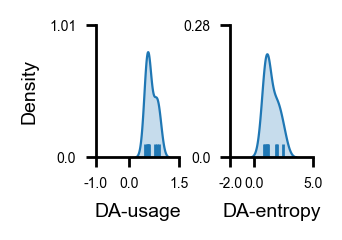

In [92]:
g = sns.displot(
    r_df.melt(),
    x="value",
    col="variable",
    col_order=["reinforcement_index_per_syllable_z", "entropy_index_per_syllable_z"],
    kind="kde",
    height=2,
    fill=True,
    aspect=0.5,
    rug=True,
    facet_kws={"sharex": False, "sharey": False},
    rug_kws={"height": 0.1},
)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_axis_labels("Value (z)", "Density")
g.axes.flat[0].set_xlim(-1, 1.5)
g.axes.flat[1].set_xlim(-2, 5)
g.fig.set_size_inches(1.5, 1)
for _ax in g.axes.flat:
    _ax.set_xlabel(aliases.get(_ax.get_title()))
    _ax.set_title("")
    clean_ticks(_ax, "x", zero_symmetry=False, precision=1, dtype=float)
    _ax.set_ylim([0, _ax.get_ylim()[1]])
    clean_ticks(_ax, "y", zero_symmetry=False, precision=2)
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], "differential_analysis_intercept_distributions"
    ),
)

# Check if reinforcement index breaks down by syllable or syllable class

In [93]:
per_syllable_reinforcement_index_average = reinforcement_index_per_syllable_z.rename(
    "reinforcement_index_per_syllable"
).reset_index()
per_syllable_reinforcement_index_average[
    "class"
] = per_syllable_reinforcement_index_average["syllable"].map(syllable_map)

In [94]:
per_syllable_reinforcement_index_average = per_syllable_reinforcement_index_average.loc[per_syllable_reinforcement_index_average["syllable"].isin(sorted_syllables[: syllable_stats["truncate"]])]

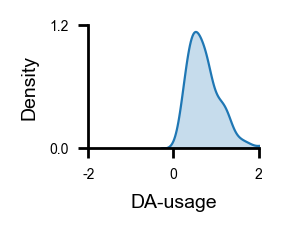

In [95]:
fig, ax = plt.subplots(1, figsize=(1.1, 0.8))
sns.kdeplot(
    data=per_syllable_reinforcement_index_average["reinforcement_index_per_syllable"],
    fill=True,
    ax=ax,
    legend=False,
)
ax.set_xlabel("DA-usage")
ax.set_xlim(-0.5, 2)
sns.despine()
clean_ticks(ax, "x", dtype=int, precision=0)
clean_ticks(ax, "y", precision=1)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"], "differential_analysis_da-usage_distribution"
    ),
)

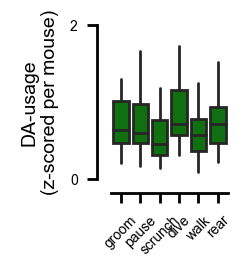

In [96]:
fig, ax = plt.subplots(1, figsize=(0.75, 1))
sns.boxplot(
    data=per_syllable_reinforcement_index_average,
    x="class",
    y="reinforcement_index_per_syllable",
    showfliers=False,
    showcaps=False,
    color="g",
)
plt.xlabel("")
plt.ylabel("DA-usage\n(z-scored per mouse)")
clean_ticks(ax, "y", precision=0, dtype=int, zero_symmetry=False)
ax.tick_params("x", rotation=45)
sns.despine(offset=5)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        "differential_analysis_da-usage_distribution_syllabletype",
    ),
)

In [97]:
per_syllable_entropy_index_average = (
    entropy_index_per_syllable_z.groupby("mouse_id")
    .apply(zscore)
    .rename("entropy_index_per_syllable")
    .reset_index()
)
per_syllable_entropy_index_average["class"] = per_syllable_entropy_index_average[
    "syllable"
].map(syllable_map)

/tmp/ipykernel_1389598/3219241849.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(zscore)


In [98]:
learning_per_syllable["class"] = learning_per_syllable.index.get_level_values(
    "target_syllable"
).map(syllable_map)

In [99]:
da_per_mouse_and_syllable = dlight_and_scalar_df.groupby(["syllable", "mouse_id"])[
    "signal_reref_dff_z_max_(0.0, 0.3)"
].mean()


In [100]:
pd.concat(
    [
        reinforcement_index_per_syllable_z.groupby("mouse_id")
        .apply(lambda x: x.rank())
        .groupby("syllable")
        .mean(),
        da_per_mouse_and_syllable.groupby("mouse_id")
        .apply(lambda x: x.rank())
        .groupby("syllable")
        .mean(),
    ],
    axis=1,
).corr()

/tmp/ipykernel_1389598/2480351543.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.rank())
/tmp/ipykernel_1389598/2480351543.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.rank())


,reinforcement_index_per_syllable_z,"signal_reref_dff_z_max_(0.0, 0.3)"
reinforcement_index_per_syllable_z,1.000000,-0.018657
"signal_reref_dff_z_max_(0.0, 0.3)",-0.018657,1.000000


In [101]:
totals = tm_df_rows.groupby(["syllable", "mouse_id"]).sum()
totals_sz = totals.apply(lambda x: x.sum())
ents_per_mouse_and_syllable = totals.progress_apply(
    lambda x: dm_entropy(
        x[: syllable_stats["truncate"]],
        alpha=1.0 / syllable_stats["truncate"],
        marginalize=False,
        axis=None,
    )
).rename("entropy_out_per_syllable_and_mouse")

  0%|          | 0/1102 [00:00<?, ?it/s]

In [102]:
totals = tm_df_rows.groupby(["syllable"]).sum()
ents_per_syllable = totals.progress_apply(
    lambda x: dm_entropy(
        x[: syllable_stats["truncate"]],
        alpha=1.0 / syllable_stats["truncate"],
        marginalize=False,
        axis=None,
    )
).rename("entropy_out_per_syllable")

  0%|          | 0/58 [00:00<?, ?it/s]

In [103]:
include_scalars = [
    "velocity_2d_mm_mean",
    "velocity_angle_mean",
    "velocity_height_mean",
]

In [104]:
full_df = (
    pd.concat(
        [
            dlight_and_scalar_df.groupby(["mouse_id", "syllable"])[
                include_scalars
            ].mean(),
            learning_per_syllable.groupby(["mouse_id", "syllable"]).mean(),
            da_stats_df.reset_index()
            .rename(columns={"target_syllable": "syllable"})
            .groupby(["mouse_id", "syllable"])
            .mean()
            .filter(regex="catch|stim|dlight"),
        ],
        axis=1,
    )
    .join(ents_per_mouse_and_syllable)
    .join(
        ents_per_mouse_and_syllable.loc[targets]
        .groupby("mouse_id")
        .transform(zscore)
        .rename("entropy_out_per_syllable_and_mouse_mousez")
    )
    .join(
        ents_per_mouse_and_syllable.groupby("syllable")
        .transform(zscore)
        .rename("entropy_out_per_syllable_and_mouse_syllz")
    )
    .join(ents_per_syllable)
    .join(
        reinforcement_index_per_syllable_z.groupby("syllable")
        .mean()
        .rename("reinforcement_index_per_syllable")
    )
    .join(
        reinforcement_index_per_syllable_z.groupby("mouse_id")
        .mean()
        .rename("reinforcement_index_per_mouse")
    )
    .join(
        reinforcement_index_per_syllable_z.rename(
            "reinforcement_index_per_syllable_and_mouse"
        )
    )
    .join(entropy_index_per_syllable_z.rename("entropy_index_per_syllable_and_mouse"))
    .join(
        reinforcement_index_per_syllable_z.groupby("mouse_id")
        .apply(zscore)
        .rename("reinforcement_index_per_syllable_and_mouse_mousez")
    )
    .join(
        reinforcement_index_per_syllable_z.groupby("syllable")
        .apply(zscore)
        .rename("reinforcement_index_per_syllable_and_mouse_syllz")
    )
    .join(
        entropy_index_per_syllable_z.dropna()
        .groupby("mouse_id")
        .apply(zscore)
        .rename("entropy_index_per_syllable_and_mouse_mousez")
    )
    .join(
        entropy_index_per_syllable_z.dropna()
        .groupby("syllable")
        .apply(zscore)
        .rename("entropy_index_per_syllable_and_mouse_syllz")
    )
)

/tmp/ipykernel_1389598/208371430.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  learning_per_syllable.groupby(["mouse_id", "syllable"]).mean(),
/tmp/ipykernel_1389598/208371430.py:51: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(zscore)
/tmp/ipykernel_1389598/208371430.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whet

In [105]:
full_df = full_df.loc[full_df.index.get_level_values("mouse_id").isin(mouse_list)]
full_df = full_df.loc[full_df.index.get_level_values("syllable").isin(targets)]

In [106]:
full_df["syllable_alias"] = full_df.index.get_level_values("syllable").map(
    syllable_aliases
)

## Get some features and let's show correlations with each

In [109]:
nshuffles = 1000

In [110]:
whiten_data = False

In [111]:
feature_df = full_df.copy()

In [112]:
feature_aliases = {
    "catch dlight (0-0.3s)": "catch DA",
    "dlight (0-0.6s)": "stim DA",
    "reinforcement_index_per_syllable_and_mouse_mousez": "DA-usage sens. (syll.)",
    "reinforcement_index_per_syllable_and_mouse_syllz": "DA-usage sens. (mouse)",
    "entropy_index_per_syllable_and_mouse_mousez": "DA-entropy sens. (syll.)",
    "entropy_index_per_syllable_and_mouse_syllz": "DA-entropy sens. (mouse)",
    "entropy_out_per_syllable_and_mouse_mousez": "entropy (syll.)",
    "entropy_out_per_syllable_and_mouse_syllz": "entropy (mouse)",
    "log2_fold_change_count_z": "opto-DA learning (z)",
}

In [113]:
show_features = [
    "catch dlight (0-0.3s)",
    "dlight (0-0.6s)",
]
learning_feature = "log2_fold_change_count_z"

In [114]:
if whiten_data:
    feature_df[show_features] = whiten(feature_df[show_features].values)[0]
    # feature_df[[y_col, "n_stim_bin"]] = whiten(feature_df[[y_col, "n_stim_bin"]].values)[0]

In [115]:
clf = pipeline.Pipeline(
    steps=[
        ("scalar", preprocessing.StandardScaler()),
        ("clf", linear_model.HuberRegressor(fit_intercept=False)),
    ]
)
splits = model_selection.RepeatedKFold(n_repeats=5, n_splits=5, random_state=0)

y_preproc = preprocessing.StandardScaler()
feature_df["learning_z"] = y_preproc.fit_transform(
    feature_df[learning_feature].values.reshape(-1, 1)
)

In [116]:
from collections import defaultdict

In [117]:
predictions = defaultdict(list)
observations = defaultdict(list)
plot_predictions = defaultdict(list)
shuffle_rs = defaultdict(list)
plot_xvals = {}
y_col = "log2_fold_change_count_z"
for _feature in tqdm(show_features):
    plot_xvals[_feature] = np.linspace(
        feature_df[_feature].min(), feature_df[_feature].max(), 100
    )
    for train_idx, test_idx in splits.split(feature_df):
        train_x, train_y = (
            feature_df.iloc[train_idx][_feature],
            feature_df.iloc[train_idx][y_col],
        )
        test_x, test_y = (
            feature_df.iloc[test_idx][_feature],
            feature_df.iloc[test_idx][y_col],
        )
        clf.fit(train_x.values[:, None], train_y.values)
        predictions[_feature].append(clf.predict(test_x.values[:, None]))
        observations[_feature].append(test_y.values)
        plot_predictions[_feature].append(
            clf.predict(plot_xvals[_feature].reshape(-1, 1))
        )

    for _shuffle in tqdm(range(nshuffles)):
        _predictions = []
        _observations = []
        for train_idx, test_idx in splits.split(feature_df):
            train_x, train_y = (
                feature_df.iloc[train_idx][_feature],
                feature_df.iloc[train_idx][y_col],
            )
            test_x, test_y = (
                feature_df.iloc[test_idx][_feature],
                feature_df.iloc[test_idx][y_col],
            )
            test_x = test_x.iloc[np.random.permutation(len(test_x))]
            clf.fit(train_x.values[:, None], train_y.values)
            _predictions.append(clf.predict(test_x.values[:, None]))
            _observations.append(test_y.values)

        _tmp_observations = np.concatenate(_observations)
        _tmp_predictions = np.concatenate(_predictions)
        shuffle_rs[_feature].append(pearsonr(_tmp_observations, _tmp_predictions)[0])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## Individual feature plots – scatter and regression

In [118]:
_tmp = clf.steps[0][1]

In [119]:
setup_plotting_env()

In [120]:
point_color = sns.color_palette("bright")[0]
line_color = sns.color_palette("bright")[1]

In [121]:
def get_z(x, y, bw_adjust=1):
    from scipy.stats import gaussian_kde

    xy = np.vstack([x, y])
    kernel = gaussian_kde(xy)
    kernel.set_bandwidth(kernel.scotts_factor() * bw_adjust)
    z = kernel(xy)
    return z

In [122]:
learning_feature

'log2_fold_change_count_z'

/tmp/ipykernel_1389598/1745570348.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  rax[0].scatter(
/tmp/ipykernel_1389598/1745570348.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  rax[0].scatter(


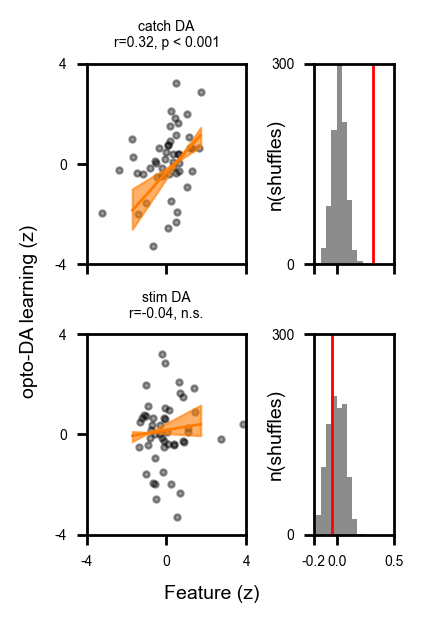

In [123]:
fig, ax = plt.subplots(
    len(show_features),
    2,
    figsize=(2, 1.5 * len(show_features)),
    sharex="col",
    sharey="col",
    constrained_layout=True,
    gridspec_kw={"width_ratios": [2, 1]},
)
# ax = ax.ravel()
for _feature, rax in zip(show_features, ax):

    lo_ci = np.quantile(np.stack(plot_predictions[_feature]), 0.025, axis=0)
    hi_ci = np.quantile(np.stack(plot_predictions[_feature]), 0.975, axis=0)
    mu = np.quantile(np.stack(plot_predictions[_feature]), 0.5, axis=0)

    lo_ci = y_preproc.inverse_transform(lo_ci.reshape(-1, 1)).ravel()
    hi_ci = y_preproc.inverse_transform(hi_ci.reshape(-1, 1)).ravel()
    mu = y_preproc.inverse_transform(mu.reshape(-1, 1)).ravel()

    shuffle_bins = np.linspace(-1, 1, 45)
    obs_r = pearsonr(
        np.concatenate(predictions[_feature]), np.concatenate(observations[_feature])
    )[0]
    pval = (obs_r < shuffle_rs[_feature]).mean()
    use_xvals = _tmp.fit_transform(plot_xvals[_feature][:, None]).ravel()

    x = _tmp.fit_transform(feature_df[_feature].values[:, None]).ravel()
    y = feature_df[learning_feature].values

    z = get_z(x, y, 1.0)
    z /= z.max()

    # rax[0].scatter(x, y, color="k", s=5, cmap="inferno_r", alpha=np.clip(z, 0, 1), rasterized=False, clip_on=True)
    rax[0].scatter(
        x, y, c="k", alpha=0.4, s=5, cmap="inferno_r", rasterized=False, clip_on=True
    )
    rax[0].fill_between(
        use_xvals, lo_ci, hi_ci, color=line_color, zorder=+200, alpha=0.6
    )
    rax[0].plot(use_xvals, mu, zorder=+250, alpha=1, color=line_color, lw=1)
    rax[0].set_title(
        f"{feature_aliases.get(_feature)}\nr={obs_r:.02f}, {format_pval(pval)[0]}",
        fontsize=5,
    )
    rax[0].set_xlim(-4, 4)
    rax[0].set_ylim(-4, 4)

    sns.histplot(
        shuffle_rs[_feature],
        ax=rax[1],
        bins=shuffle_bins,
        color=[0.4, 0.4, 0.4],
        element="step",
        fill=True,
        ec=None,
        lw=0,
    )
    rax[1].set_xlim(-0.2, 0.5)
    rax[1].axvline(x=obs_r, color="r")
    rax[1].set_ylim(0, 300)
    rax[1].set_ylabel("n(shuffles)", labelpad=-5)
    clean_ticks(rax[1], "x", zero_symmetry=False, precision=1)
    clean_ticks(rax[1], "y", zero_symmetry=False, precision=-2, dtype=int)

clean_ticks(rax[0], "x", precision=0, dtype=int)
clean_ticks(rax[0], "y", precision=0, dtype=int)
fig.supylabel(feature_aliases.get(learning_feature), fontsize=7)
fig.supxlabel("Feature (z)", fontsize=7)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"], "differential_analysis_feature_correlation_scatter"
    ),
)
# fig.tight_layout()

In [124]:
dcts = {}
for _feature in show_features:
    obs_r = pearsonr(
        np.concatenate(predictions[_feature]), np.concatenate(observations[_feature])
    )[0]
    pval = (obs_r < shuffle_rs[_feature]).mean()
    n = len(np.concatenate(predictions[_feature]))
    dcts[_feature] = {
        "r": obs_r,
        "p": pval,
        "n": n,
        "n_definition": "per-mouse/syllable pairs",
    }

In [125]:
with open(
    os.path.join(
        proc_dirs["dlight"], "reinforcement_index_stats_individual_feature_models.toml"
    ),
    "w",
) as f:
    toml.dump(dcts, f)

In [126]:
mouse_list = [_ for _ in mouse_list if "chrimson" in _]